In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import gdown
from zipfile import ZipFile 
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from typing_extensions import Required
from torch.utils.data import Dataset, DataLoader
import sys
import glob
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
from torchvision.utils import save_image

/home/jorge/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda:0


In [3]:
def read_data(path,resize_fact):
    images = []
    for i, image in enumerate(path):
        image = cv.imread(image)
        image = cv.resize(image, resize_fact)
        images.append(image)
    return images

In [4]:
DATASET_DIR='data/'
TEST_DIR = DATASET_DIR+'test/'
TRAIN_DIR = DATASET_DIR+'train/'
TRAIN_CLEAN = DATASET_DIR+'train_cleaned/'
files_train = glob.glob(TRAIN_DIR+ '*.png')
files_test = glob.glob(TEST_DIR+ '*.png')
files_train_clean = glob.glob(TRAIN_CLEAN+'*.png')

resize_factor = (256,256)

train_set =   read_data(files_train,resize_fact=resize_factor)
images_test =  read_data(files_test,resize_fact=resize_factor)
images_clean = read_data(files_train_clean,resize_fact=resize_factor)

trasform = transform.Compose([
    transform.ToPILImage(),
    transform.ToTensor()
])


In [7]:
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#Creamos el dataset para poder enviarlo al dataloader
class imageSet(Dataset):
    def __init__(self, X, Y=None, T=None):
        self.x = X
        self.y = Y
        self.transforms = T
         
    def __len__(self):
        return (len(self.x))
    
    def __getitem__(self, idx):
        data = self.x[idx][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            labels = self.y[idx][:]
            labels = self.transforms(labels)
            return (data, labels)
        else:
            return data

In [8]:
data_train = imageSet(train_set,images_clean,trasform)
data_test = imageSet(images_test,None,trasform)

train_loader = DataLoader(data_train,batch_size=2,shuffle=True)
test_loader = DataLoader(data_test,batch_size=2,shuffle=True)


In [54]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3,padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn = nn.BatchNorm2d(64)
   

  def forward(self, image):
  
    out = self.conv1(image)
    out = F.relu(out)
    out = self.pool(out)
    
    out = self.conv2(out)
    out = F.relu(out)
    out = self.bn(out)
    out = self.pool(out)

    return out

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.convTran1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  
    self.convTran2 = nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2)
    self.out = nn.ConvTranspose2d(128, 3, kernel_size=3, padding=1)
    self.dropout = nn.Dropout(p=0.5)
    self.bn = nn.BatchNorm2d(64)
    self.unpool = nn.MaxUnpool2d(2, stride=2)

  def forward(self, latent):
    out = latent
    out = self.convTran1(latent)
    out = F.relu(out)
    out = self.bn(out)
    out = self.convTran2(out)
    out = F.relu(out)
    out = self.out(out)
    out = torch.sigmoid(out)
    return out

In [55]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return  x_recon

In [56]:
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
criterion  = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

In [57]:
# the training function
def train(net, train_loader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in train_loader:
            img = data[0]
            labels = data[1]
            img = img.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, NUM_EPOCHS, loss)) 
    return train_loss

In [58]:
autoencoder.train()
loss_result = train(autoencoder,train_loader,20)

Epoch [1 / 20] average reconstruction error: 0.036601
Epoch [2 / 20] average reconstruction error: 0.013754
Epoch [3 / 20] average reconstruction error: 0.010443
Epoch [4 / 20] average reconstruction error: 0.008841
Epoch [5 / 20] average reconstruction error: 0.007517
Epoch [6 / 20] average reconstruction error: 0.006922
Epoch [7 / 20] average reconstruction error: 0.006455
Epoch [8 / 20] average reconstruction error: 0.005993
Epoch [9 / 20] average reconstruction error: 0.005650
Epoch [10 / 20] average reconstruction error: 0.005220
Epoch [11 / 20] average reconstruction error: 0.005062
Epoch [12 / 20] average reconstruction error: 0.004896
Epoch [13 / 20] average reconstruction error: 0.004638
Epoch [14 / 20] average reconstruction error: 0.004534
Epoch [15 / 20] average reconstruction error: 0.004347
Epoch [16 / 20] average reconstruction error: 0.004286
Epoch [17 / 20] average reconstruction error: 0.004148
Epoch [18 / 20] average reconstruction error: 0.004057
Epoch [19 / 20] ave

In [188]:
def Show(out, title = ''):
  print(title) # out = out.permute(1,0,2)
  # grilla = torchvision.utils.make_grid(out,10,5)
  # plt.imshow(transform.ToPILImage()(grilla), 'jet')
  # plt.show()
  tensor = tensor.cpu().numpy() # make sure tensor is on cpu 
  cv.imwrite(tensor, "image.png") 
 

In [220]:
def test(net, test_loader):
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            img = data
            #print("eNTRAR",img.shape)
            img = img.to(device)
            outputs = net(img)
            # print(outputs[0].shape)
            # print(outputs[0].shape)
            # plt.imshow(outputs[0].permute(1, 2, 0)); plt.show() 
            #preds_0 = outputs[0].reshape(256, 256,3)
            #plt.imshow(preds_0,cmap='gray'); plt.show()
            image = outputs.cpu()
            #Show(outputs, 'Test {}'.format(i+1))
            img = img.view(image.size(0), 3, 256, 256)
            save_image(img, 'results/test{}.png'.format(i+1))
           

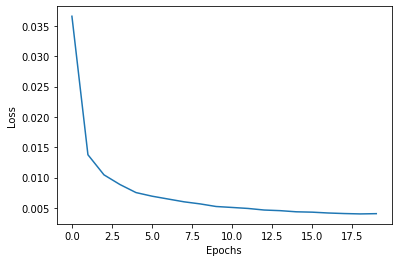

In [60]:
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss_plot.png')
plt.show()

In [ ]:
test(autoencoder,test_loader)

In [139]:
print(len(test_loader))

36


In [24]:
import torch
torch.cuda.empty_cache()

In [48]:
import gc
del autoencoder
gc.collect()


3563